## battery, metal class Up-sampling

In [11]:
!ls

k-fold	   new_k-fold_v1      old_k-fold      test	 train
k-fold-up  new_train_v1.json  old_train.json  test.json  train.json


In [12]:
import cv2
import numpy as np
from pycocotools.coco import COCO
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from PIL import Image
import json

In [3]:
os.chdir('dataset')
!ls

k-fold	   new_k-fold_v1      old_k-fold      test	 train
k-fold-up  new_train_v1.json  old_train.json  test.json  train.json


In [13]:
# ================== TODO ===========================
read_train_json = 'train.json'       # 읽을 train json 파일
write_train_json = 'train_up.json'           # 쓸 train json 파일
read_val_json = 'k-fold/valid_fold0.json'         # 읽을 val json 파일
write_val_json = 'k-fold-up/valid_fold0up.json'             # 쓸 val json 파일
img_folder_dir = 'train'                          # 이미지 파일을 저장할 폴더명
battery_only = True
# ===================================================
# Set the output directory for augmented images
if not os.path.exists(img_folder_dir):
    os.makedirs(img_folder_dir)

with open(read_train_json, 'r') as f:
    data = json.load(f)
    images = data['images']
    categories = data['categories']
    annotations = data['annotations']

## 적용할 Augmentation

In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
transform = A.Compose([
    A.HorizontalFlip(p=0.7),
    A.VerticalFlip(p=0.7),
    A.Rotate(limit=30, p=0.7),
    A.RandomBrightnessContrast(brightness_limit=[0.1, 0.5],
        contrast_limit=[0.1, 0.3],
        p=0.2),
], bbox_params=A.BboxParams(format='coco', label_fields=['category_id']))

## 예시 이미지 출력

In [15]:
if battery_only:
    battery_metal_image_id = [ann['image_id'] for ann in annotations if ann['category_id']==8 
                            # or ann['category_id']==3
                            ]
else:
    battery_metal_image_id = [ann['image_id'] for ann in annotations if ann['category_id']==8 
                            or ann['category_id']==3
                            ]

print(battery_metal_image_id)
print(len(battery_metal_image_id))
train_ann_num = len(battery_metal_image_id) # val에 사용
battery_metal_image_id = list(set(battery_metal_image_id))
print(battery_metal_image_id)
print(len(battery_metal_image_id))
train_img_num = len(battery_metal_image_id) # val에 사용

[92, 92, 126, 204, 291, 291, 291, 291, 291, 291, 291, 291, 291, 319, 319, 319, 449, 555, 555, 557, 557, 557, 628, 628, 628, 635, 635, 643, 675, 675, 675, 675, 675, 675, 675, 675, 821, 821, 879, 879, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 949, 1154, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1157, 1175, 1175, 1175, 1175, 1209, 1492, 1492, 1492, 1492, 1492, 1825, 1825, 1825, 1825, 1825, 1861, 1861, 1861, 1861, 1861, 1861, 1861, 1861, 1861, 1861, 1861, 1861, 1944, 1944, 1944, 1991, 1991, 2139, 2139, 2187, 2187, 2187, 2582, 2582, 2763, 2763, 2812, 2812, 2871, 2871, 2871, 3122, 3122, 3122, 3292, 3292, 3292, 3360, 3360, 3377, 3549, 3549, 3549, 3886, 3930, 3930, 3996, 3996, 3997, 3997, 3997, 3997, 3997, 3997, 4087, 4143, 4185, 4185, 4185, 4285, 4285, 4285, 4285, 4285, 4285, 4285, 4285, 4341, 4341, 4385, 4555, 4555, 4555, 4555, 4867, 4867]
160
[1154, 643, 4867, 1157, 2187, 2582, 1175, 1944, 3996, 3997, 3360, 1825, 4385, 291, 675, 555, 557,

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


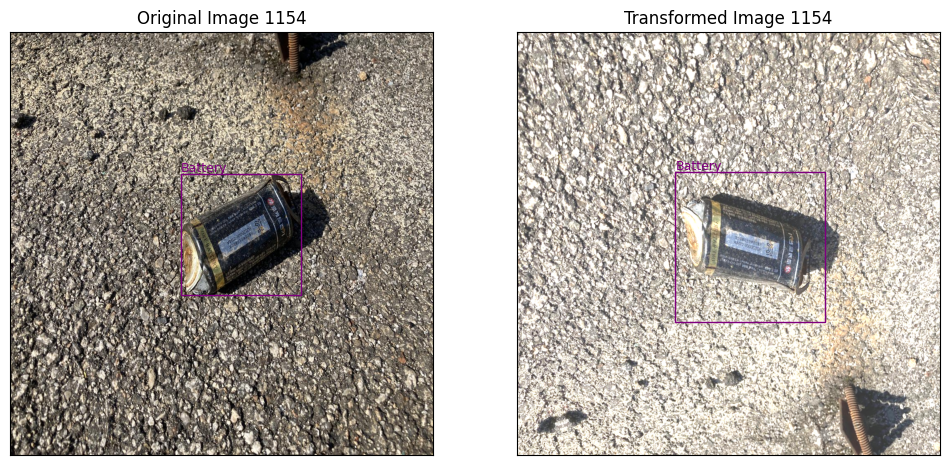

In [16]:
# 예시 이미지 출력해보기
coco = COCO(read_train_json)

n = battery_metal_image_id[0]
image_id = coco.getImgIds(imgIds=n)
image_info = coco.loadImgs(image_id)[0]

box = [x['bbox'] for x in coco.loadAnns(coco.getAnnIds(imgIds=image_info['id']))]
cat = [coco.loadCats(x['category_id'])[0]['name'] for x in coco.loadAnns(coco.getAnnIds(imgIds=image_info['id']))]

img = cv2.imread(image_info['file_name'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img /= 255.0

classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
LABELCOLORS = ['red', 'orange', 'yellow', 'greenyellow', 'green', 'turquoise', 'blue', 'indigo', 'purple', 'black']

transformed = transform(image=img, bboxes=box, category_id=cat)
transformed_img = transformed['image']
transformed_bboxes = transformed['bboxes']

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].set_xticks([])
ax[0].set_yticks([])

# plot original image
ax[0].imshow(img)
for (x, y, w, h), c in zip(box, cat):
    label_color = LABELCOLORS[classes.index(c)]
    ax[0].add_patch(patches.Rectangle((x, y), w, h, edgecolor=label_color, linewidth=1, fill=False))
    ax[0].text(x, y-5, c, fontsize=9, color=label_color)
ax[0].set_title(f'Original Image {n}')

ax[1].set_xticks([])
ax[1].set_yticks([])

ax[1].imshow(np.transpose(transformed_img, (0, 1, 2)))
for (x, y, w, h), c in zip(transformed_bboxes, cat):
    label_color = LABELCOLORS[classes.index(c)]
    ax[1].add_patch(patches.Rectangle((x, y), w, h, edgecolor=label_color, linewidth=1, fill=False))
    ax[1].text(x, y-5, c, fontsize=9, color=label_color)
ax[1].set_title(f'Transformed Image {n}')

plt.show()

## Train dataset Up-sampling

In [17]:
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
LABELCOLORS = ['red', 'orange', 'yellow', 'greenyellow', 'green', 'turquoise', 'blue', 'indigo', 'purple', 'black']

if battery_only:
    battery_metal_image_id = [ann['image_id'] for ann in annotations if ann['category_id']==8 
                            # or ann['category_id']==3
                            ]
else:
    battery_metal_image_id = [ann['image_id'] for ann in annotations if ann['category_id']==8 
                            or ann['category_id']==3
                            ]
battery_metal_image_id = list(set(battery_metal_image_id))

# num은 새로 만든 train.json 기준
image_num = 4883
annotation_num = 24344

coco = COCO(read_train_json)
for n in range(3):  # 몇 배 up-sampling 시킬지 (3배)
    print('======== ', n ,' =========')
    for bii in battery_metal_image_id: # battery가 포함된 image_id 들
        print('current image_id :', bii)
        image_id = coco.getImgIds(imgIds=bii)
        image_info = coco.loadImgs(image_id)[0]

        box = [x['bbox'] for x in coco.loadAnns(coco.getAnnIds(imgIds=image_info['id']))]
        cat = [coco.loadCats(x['category_id'])[0]['name'] for x in coco.loadAnns(coco.getAnnIds(imgIds=image_info['id']))]

        img = cv2.imread(image_info['file_name'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0

        transformed = transform(image=img, bboxes=box, category_id=cat)
        transformed_img = transformed['image']
        transformed_bboxes = transformed['bboxes']

        # 이미지 저장
        image_num += 1
        images.append({
            'width': transformed_img.shape[0],
            'height': transformed_img.shape[1],
            'file_name': img_folder_dir+'/'+str(image_num)+'.jpg',
            'license': 0,
            'flickr_url': None,
            'coco_url': None,
            'date_captured': None,
            'id': image_num
        })
        # 변환된 이미지 파일 저장
        transformed_img = Image.fromarray((transformed_img * 255).astype(np.uint8))
        transformed_img.save(img_folder_dir+"/"+str(image_num)+'.jpg')

        # annotations 저장
        for (x, y, w, h), c in zip(transformed_bboxes, cat):
            annotation_num += 1
            annotations.append({
                'image_id': image_num,
                'category_id': classes.index(c),
                'area': round(w*h, 2),
                'bbox': [round(x, 1), round(y, 1), round(w, 1), round(h, 1)],
                'iscrowd': 0,
                'id': annotation_num})

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
========  0  =========
current image_id : 1154
current image_id : 643
current image_id : 4867
current image_id : 1157
current image_id : 2187
current image_id : 2582
current image_id : 1175
current image_id : 1944
current image_id : 3996
current image_id : 3997
current image_id : 3360
current image_id : 1825
current image_id : 4385
current image_id : 291
current image_id : 675
current image_id : 555
current image_id : 557
current image_id : 3886
current image_id : 4143
current image_id : 3377
current image_id : 3122
current image_id : 821
current image_id : 949
current image_id : 2871
current image_id : 1209
current image_id : 4285
current image_id : 319
current image_id : 449
current image_id : 1861
current image_id : 1991
current image_id : 2763
current image_id : 204
current image_id : 4555
current image_id : 1492
current image_id : 4185
current image_id : 3930
current image_id : 2139
current image_id

In [18]:
# json 파일 저장
with open(write_train_json, 'w') as f:
    json.dump({ 'images': images, 
            'annotations': annotations, 'categories': categories}, f)

## Validation dataset Up-sampling

In [29]:
with open(read_val_json, 'r') as f:
    data = json.load(f)
    images = data['images']
    categories = data['categories']
    annotations = data['annotations']

In [30]:
battery_image_id = [ann['image_id'] for ann in annotations if ann['category_id']==8 or ann['category_id'] == 3]
print(battery_image_id)
print(len(battery_image_id))
battery_image_id = list(set(battery_image_id))
print(battery_image_id)
print(len(battery_image_id))

[1, 44, 64, 70, 120, 127, 145, 156, 170, 233, 259, 323, 323, 323, 323, 323, 323, 350, 350, 397, 397, 409, 415, 433, 449, 501, 508, 513, 571, 587, 587, 686, 691, 959, 1037, 1099, 1178, 1236, 1236, 1312, 1330, 1371, 1390, 1404, 1417, 1423, 1457, 1471, 1521, 1521, 1521, 1521, 1521, 1521, 1521, 1589, 1597, 1614, 1634, 1665, 1748, 1782, 1786, 1806, 1857, 1857, 1870, 1944, 1944, 1944, 1946, 1946, 1966, 1970, 1991, 1991, 1997, 2074, 2136, 2139, 2139, 2169, 2169, 2169, 2368, 2418, 2418, 2418, 2418, 2418, 2418, 2439, 2439, 2469, 2598, 2608, 2608, 2660, 2660, 2669, 2674, 2684, 2708, 2769, 2777, 2821, 2821, 2953, 2953, 2953, 2953, 2953, 2953, 2953, 2984, 2984, 3017, 3023, 3035, 3044, 3047, 3047, 3047, 3053, 3115, 3115, 3115, 3115, 3115, 3162, 3162, 3208, 3208, 3226, 3242, 3332, 3332, 3386, 3429, 3439, 3541, 3549, 3549, 3549, 3668, 3704, 3704, 3704, 3704, 3704, 3704, 3704, 3704, 3704, 3704, 3704, 3704, 3704, 3704, 3704, 3704, 3704, 3704, 3707, 3726, 3726, 3728, 3752, 3807, 3807, 3826, 3884, 3996, 

In [31]:
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]
LABELCOLORS = ['red', 'orange', 'yellow', 'greenyellow', 'green', 'turquoise', 'blue', 'indigo', 'purple', 'black']

if battery_only:
    battery_metal_image_id = [ann['image_id'] for ann in annotations if ann['category_id']==8 
                            # or ann['category_id']==3
                            ]
else:
    battery_metal_image_id = [ann['image_id'] for ann in annotations if ann['category_id']==8 
                            or ann['category_id']==3
                            ]
battery_metal_image_id = list(set(battery_metal_image_id))

# num은 train.json 기준
image_num = 4883+train_img_num*3
annotation_num = 24344+train_ann_num*3

coco = COCO(read_val_json)
for n in range(3):  # 몇 배 up-sampling 시킬지 (3배)
    print('======== ', n ,' =========')
    for bii in battery_metal_image_id: # battery가 포함된 image_id 들
        print('current image_id :', bii)
        image_id = coco.getImgIds(imgIds=bii)
        image_info = coco.loadImgs(image_id)[0]

        box = [x['bbox'] for x in coco.loadAnns(coco.getAnnIds(imgIds=image_info['id']))]
        cat = [coco.loadCats(x['category_id'])[0]['name'] for x in coco.loadAnns(coco.getAnnIds(imgIds=image_info['id']))]

        img = cv2.imread(image_info['file_name'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0

        transformed = transform(image=img, bboxes=box, category_id=cat)
        transformed_img = transformed['image']
        transformed_bboxes = transformed['bboxes']

        # 이미지 저장
        image_num += 1
        images.append({
            'width': transformed_img.shape[0],
            'height': transformed_img.shape[1],
            'file_name': img_folder_dir+'/'+str(image_num)+'.jpg',
            'license': 0,
            'flickr_url': None,
            'coco_url': None,
            'date_captured': None,
            'id': image_num
        })
        # 변환된 이미지 파일 저장
        transformed_img = Image.fromarray((transformed_img * 255).astype(np.uint8))
        transformed_img.save(img_folder_dir+"/"+str(image_num)+'.jpg')

        # annotations 저장
        for (x, y, w, h), c in zip(transformed_bboxes, cat):
            annotation_num += 1
            annotations.append({
                'image_id': image_num,
                'category_id': classes.index(c),
                'area': round(w*h, 2),
                'bbox': [round(x, 1), round(y, 1), round(w, 1), round(h, 1)],
                'iscrowd': 0,
                'id': annotation_num})

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
========  0  =========
current image_id : 1
current image_id : 513
current image_id : 4107
current image_id : 1037
current image_id : 2074
current image_id : 2598
current image_id : 3115
current image_id : 44
current image_id : 2608
current image_id : 1589
current image_id : 571
current image_id : 1597
current image_id : 64
current image_id : 4163
current image_id : 70
current image_id : 587
current image_id : 1099
current image_id : 1614
current image_id : 4175
current image_id : 3668
current image_id : 2136
current image_id : 4185
current image_id : 3162
current image_id : 2139
current image_id : 1634
current image_id : 4706
current image_id : 2660
current image_id : 4707
current image_id : 2669
current image_id : 2674
current image_id : 120
current image_id : 2169
current image_id : 3704
current image_id : 3707
current image_id : 2684
current image_id : 127
current image_id : 4736
current image_id : 1

In [32]:
# json 파일 저장
with open(write_val_json, 'w') as f:
    json.dump({'images': images, 
            'annotations': annotations, 'categories': categories}, f)